## Loan Default Classification (Lending Club Predictive Analytics)

### Dataset Information
The dataset is obtained from LendingClub Statistics: https://www.lendingclub.com/info/download-data.action

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance

#pip install xgboost
#from xgboost import plot_tree
#conda install graphviz
#conda install python-graphviz

%matplotlib inline

random_seed = 170008

In [2]:
# Combine multiple data files
# Specify row count to eliminate extra rows in the end of data files
quarter_row = {'2018Q1': 107864, '2018Q2': 130772, '2018Q3': 128194, '2018Q4': 128412}
filenames = ''
cnt_append = 0

for key, value in quarter_row.items():
    filename = f'LoanStats_{key}.csv'
    df_temp = pd.read_csv(f'./{filename}', skiprows=1, nrows=value, low_memory=False)
    
    if cnt_append == 0:
        df_init = df_temp.copy()
        filenames += filename
    else:
        df_init = df_init.append(df_temp, ignore_index=True)
        filenames += ', ' + filename
    
    cnt_append += 1
    
print(f'{cnt_append} data files ({filenames}) appended.')

display(df_init[:5])
print('There are %d rows and %d columns in dataframe.' % (df_init.shape))

4 data files (LoanStats_2018Q1.csv, LoanStats_2018Q2.csv, LoanStats_2018Q3.csv, LoanStats_2018Q4.csv) appended.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,25000,25000,25000.0,60 months,21.85%,688.35,D,D5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,10000,10000,10000.0,60 months,12.61%,225.54,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,11200,11200,11200.0,60 months,30.79%,367.82,G,G1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,6500,6500,6500.0,36 months,6.07%,197.95,A,A2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,6000,6000,6000.0,36 months,10.41%,194.77,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


There are 495242 rows and 144 columns in dataframe.


In [3]:
# Work on a copy of the dataframe so that don't have to reload the dataset
df = df_init.copy()

In [4]:
# Function to check columns for missing values
def check_null(df):
    col_dtype = df.dtypes
    null_val_num = df.isnull().sum()
    null_val_perc = round(null_val_num / df.shape[0] * 100, 2)
    
    df_null_val = pd.concat([col_dtype, null_val_num, null_val_perc], axis=1, sort=True).rename(
        columns={0: 'Data Type', 1: 'Null Values (#)', 2: 'Null Values (%)'})
    df_null_val = df_null_val.sort_values('Null Values (#)', ascending=False)
    
    cnt_null_col = df_null_val[df_null_val['Null Values (#)'] != 0].shape[0]
    print(f'Dataframe has {df.shape[1]} columns, {cnt_null_col} of them have missing values.')
    
    return df_null_val

In [5]:
# Missing value statistics
df_null_val = check_null(df)

display(df_null_val[df_null_val['Null Values (#)'] != 0])

Dataframe has 144 columns, 62 of them have missing values.


,Data Type,Null Values (#),Null Values (%)
desc,float64,495242,100.00
member_id,float64,495242,100.00
id,float64,495242,100.00
url,float64,495242,100.00
orig_projected_additional_accrued_interest,float64,494867,99.92
hardship_type,object,494804,99.91
hardship_status,object,494804,99.91
hardship_start_date,object,494804,99.91
hardship_payoff_balance_amount,float64,494804,99.91
hardship_loan_status,object,494804,99.91


In [6]:
# Drop columns with more than 70% missing value
col_null = df_null_val[df_null_val['Null Values (%)'] > 70].index.tolist()
df = df.drop(columns=col_null)
print(f'{len(col_null)} columns dropped.')

display(df[:5])
print('There are %d rows and %d columns in dataframe.' % (df.shape))

42 columns dropped.


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,25000,25000,25000.0,60 months,21.85%,688.35,D,D5,Asphalt Supervisor,10+ years,...,75.0,100.0,0,0,101234,17039,3300,10220,N,N
1,10000,10000,10000.0,60 months,12.61%,225.54,C,C1,Supervisor,4 years,...,91.3,40.0,0,0,388400,10710,12500,0,N,N
2,11200,11200,11200.0,60 months,30.79%,367.82,G,G1,Client services,< 1 year,...,71.4,0.0,0,0,80367,67173,1900,74167,N,N
3,6500,6500,6500.0,36 months,6.07%,197.95,A,A2,dental assistant,10+ years,...,93.8,20.0,0,0,289008,8665,39000,6500,N,N
4,6000,6000,6000.0,36 months,10.41%,194.77,B,B3,Dental Hygienist,1 year,...,100.0,50.0,0,0,31925,17000,5200,13125,N,N


There are 495242 rows and 102 columns in dataframe.


In [7]:
# Label continuous, categorical, unnecessary and target variables
# Continuous variables
var_contns = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment',
              'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
              'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
              'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
              'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
              'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
              'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
              'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
              'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
              'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
              'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
              'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
              'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
              'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
              'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
              'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']

# Categorical variables
var_ctgry = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
             'verification_status', 'pymnt_plan', 'purpose', 'title', 'initial_list_status',
             'application_type', 'hardship_flag', 'debt_settlement_flag']

# Unnecessary variables
var_drop = ['emp_title', 'zip_code', 'addr_state', # Too many categories
            'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', # Date
            'policy_code', # Only single category
            'num_tl_120dpd_2m' # Only single or missing value
           ]

# Target variable
var_target = 'loan_status'

In [8]:
# Display emp_title categories
display(df['emp_title'].value_counts())

Teacher                                8679
Manager                                8008
Owner                                  5481
Driver                                 4308
Registered Nurse                       3633
Supervisor                             3067
RN                                     2981
Sales                                  2919
Project Manager                        2315
Office Manager                         2219
General Manager                        2027
Director                               1802
owner                                  1680
Engineer                               1525
President                              1505
Truck Driver                           1415
Operations Manager                     1404
Nurse                                  1358
manager                                1259
Accountant                             1197
Sales Manager                          1186
Supervisor                             1183
Server                          

In [9]:
# Drop unnecessary variables
df = df.drop(columns=var_drop)
print(f'{len(var_drop)} columns dropped.')

display(df[:5])
print('There are %d rows and %d columns in dataframe.' % (df.shape))

10 columns dropped.


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,25000,25000,25000.0,60 months,21.85%,688.35,D,D5,10+ years,MORTGAGE,...,75.0,100.0,0,0,101234,17039,3300,10220,N,N
1,10000,10000,10000.0,60 months,12.61%,225.54,C,C1,4 years,MORTGAGE,...,91.3,40.0,0,0,388400,10710,12500,0,N,N
2,11200,11200,11200.0,60 months,30.79%,367.82,G,G1,< 1 year,RENT,...,71.4,0.0,0,0,80367,67173,1900,74167,N,N
3,6500,6500,6500.0,36 months,6.07%,197.95,A,A2,10+ years,MORTGAGE,...,93.8,20.0,0,0,289008,8665,39000,6500,N,N
4,6000,6000,6000.0,36 months,10.41%,194.77,B,B3,1 year,RENT,...,100.0,50.0,0,0,31925,17000,5200,13125,N,N


There are 495242 rows and 92 columns in dataframe.


In [10]:
# Convert string type continuous variables to numeric
print('Before conversion:')
display(df.loc[:4, ['int_rate', 'revol_util']])

# int_rate
df['int_rate'] = round(pd.Series([x[:-1] for x in df['int_rate']]).astype('float64') / 100, 4)

# revol_util
df['revol_util'] = round(pd.Series([x[:-1] if isinstance(x, str) else x
                       for x in df.loc[~df['revol_util'].isnull(), 'revol_util']]).astype('float64') / 100, 3)

print('After conversion:')
display(df.loc[:4, ['int_rate', 'revol_util']])

Before conversion:


,int_rate,revol_util
0,21.85%,98.4%
1,12.61%,37.7%
2,30.79%,24.6%
3,6.07%,20.2%
4,10.41%,29.6%


After conversion:


,int_rate,revol_util
0,0.2185,0.984
1,0.1261,0.377
2,0.3079,0.246
3,0.0607,0.202
4,0.1041,0.296


In [11]:
# Create target variable (1 - 'DEFAULT', 0 - 'NON-DEFAULT')
target_list = ['DEFAULT' if x in ['Default', 'Charged Off'] else 'NON-DEFAULT' for x in df['loan_status']]
target_dict = {'DEFAULT': 1, 'NON-DEFAULT': 0}

df['TARGET'] = target_list
display(df['TARGET'].value_counts())

NON-DEFAULT    485302
DEFAULT          9940
Name: TARGET, dtype: int64

In [12]:
# Function to add value labels on a matplotlib bar chart
# Refer to https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=0):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        #label = "{:.1f}".format(y_value)
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

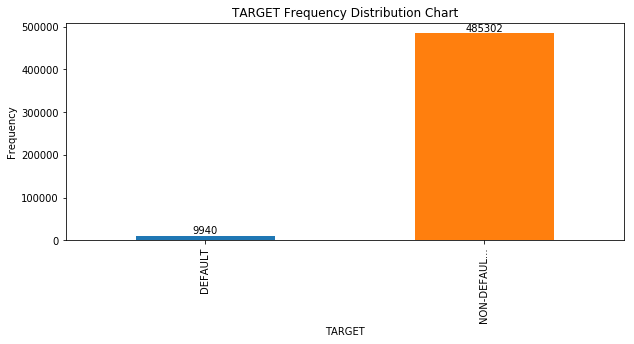

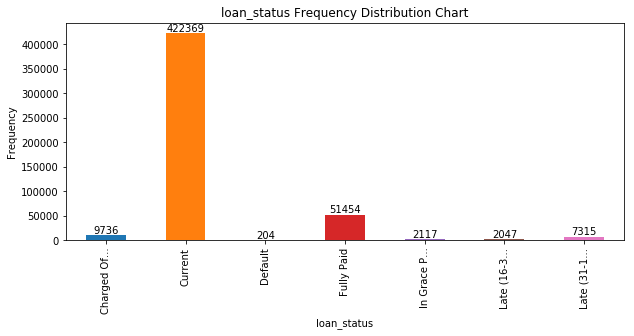

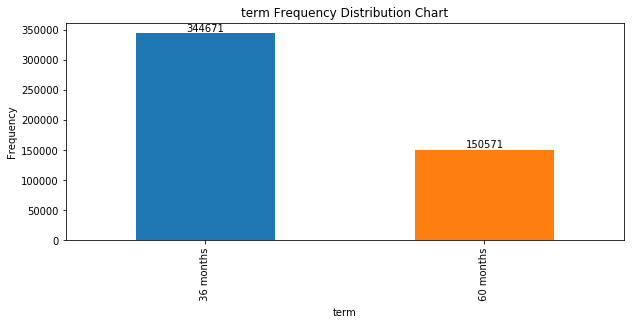

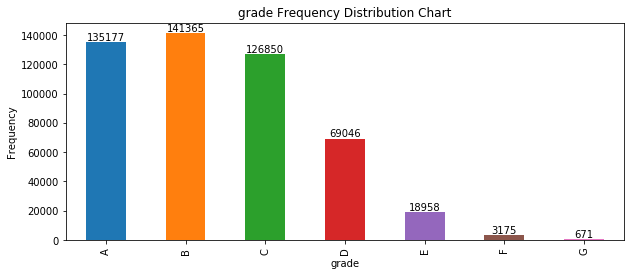

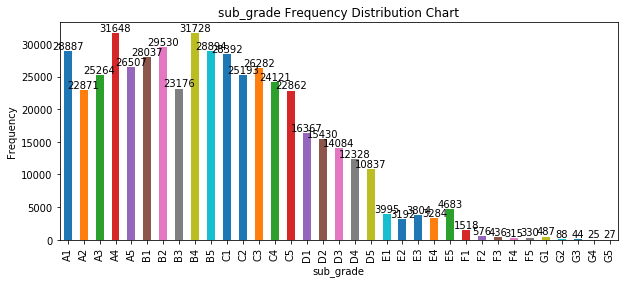

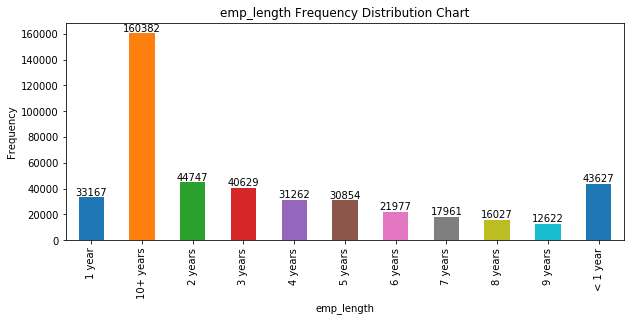

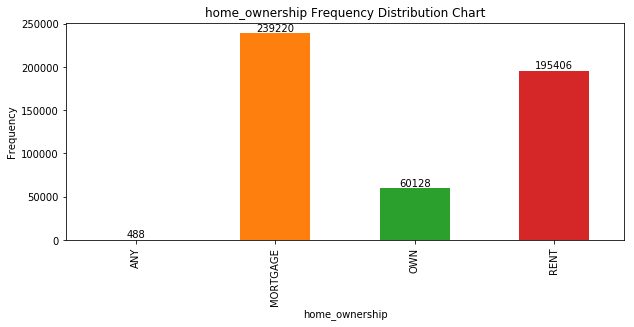

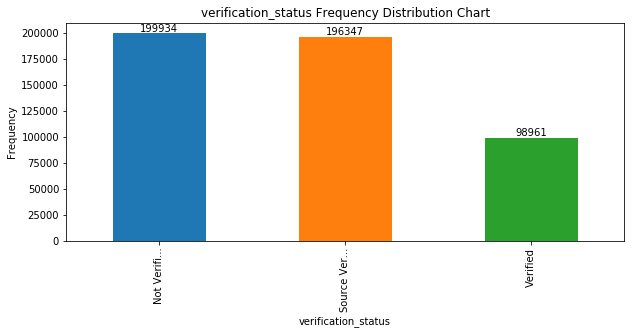

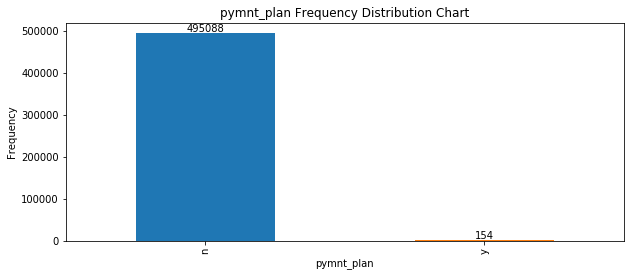

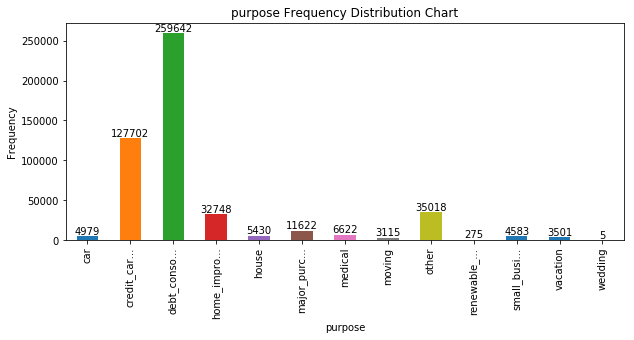

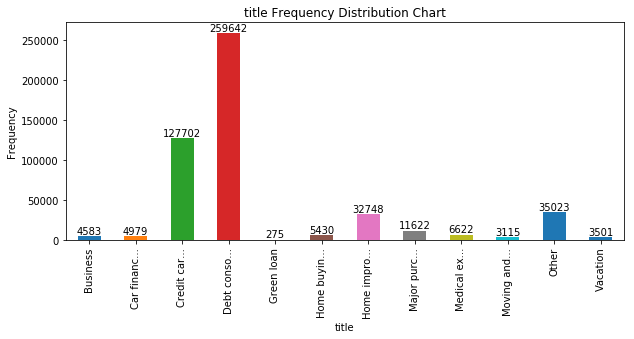

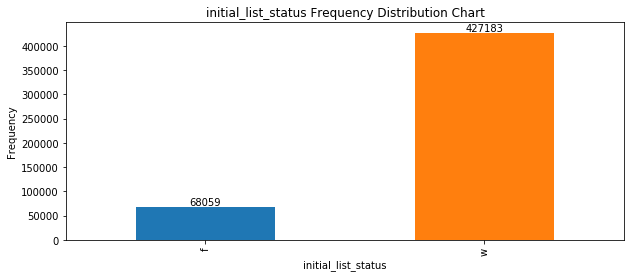

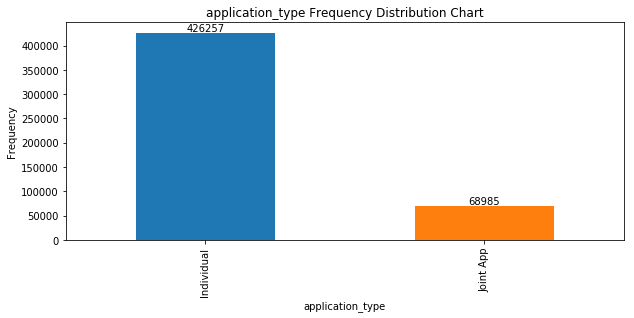

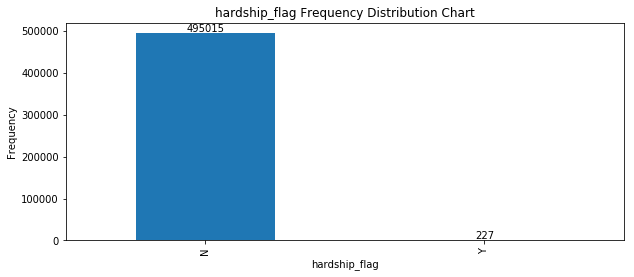

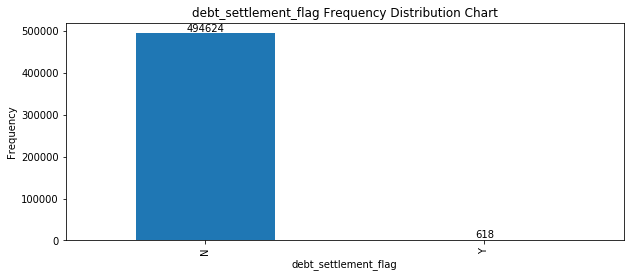

In [13]:
# Display Frequency Distribution Chart of each categorical variable
for var in ['TARGET', var_target] + var_ctgry:
    plt.figure(figsize=[10, 4])
    ax = df[var].value_counts().sort_index().plot(kind='bar')
    ax.set_title(f'{var} Frequency Distribution Chart')
    ax.set_xlabel(f'{var}')
    ax.set_ylabel('Frequency')
    ax.set_xticklabels([x[:10] + '...' if len(x) > 10 else x for x in sorted(
        df[var].value_counts().index)])
    add_value_labels(ax)
    plt.show()

In [14]:
# Display Descriptive Statistics Table of continuous variables
df_desc_stat = df[var_contns].describe().T
df_desc_stat = df_desc_stat.drop(columns=['count'])
df_desc_stat = round(df_desc_stat, 2)

display(df_desc_stat[:5])
print(f'Dataframe has {df_desc_stat.shape[0]} continuous variables with {df_desc_stat.shape[1]} measures.')

,mean,std,min,25%,50%,75%,max
loan_amnt,16025.02,10138.08,1000.00,8000.00,14000.00,22000.00,40000.00
funded_amnt,16025.02,10138.08,1000.00,8000.00,14000.00,22000.00,40000.00
funded_amnt_inv,16021.67,10137.90,725.00,8000.00,14000.00,22000.00,40000.00
int_rate,0.13,0.05,0.05,0.08,0.12,0.16,0.31
installment,466.61,286.91,29.76,254.56,386.82,629.04,1670.15


Dataframe has 78 continuous variables with 7 measures.


In [15]:
# Pearson correlation analysis between TARGET and continuous variables
# Convert TARGET to numeric type for calculating correlation
df['TARGET'] = df['TARGET'].replace(target_dict)

df_contns_corr = pd.DataFrame(round(df[var_contns + ['TARGET']].corr()['TARGET']
    .sort_values(ascending=False), 4)).rename(columns={'TARGET': 'Corr. Coef.'})
df_contns_corr = df_contns_corr.loc[(df_contns_corr.index != 'TARGET')]

df_contns_pos_corr = df_contns_corr[:10]
print('Top 10 TARGET +ve Correlated Continuous Variables:')
display(df_contns_pos_corr)

df_contns_neg_corr = df_contns_corr[-10:].sort_values('Corr. Coef.')
print('Top 10 TARGET -ve Correlated Continuous Variables:')
display(df_contns_neg_corr)

Top 10 TARGET +ve Correlated Continuous Variables:


,Corr. Coef.
recoveries,0.3634
collection_recovery_fee,0.3580
int_rate,0.0963
total_rec_late_fee,0.0588
inq_last_6mths,0.0462
inq_last_12m,0.0401
num_tl_op_past_12m,0.0297
open_acc_6m,0.0264
acc_open_past_24mths,0.0260
inq_fi,0.0249


Top 10 TARGET -ve Correlated Continuous Variables:


,Corr. Coef.
out_prncp,-0.1743
out_prncp_inv,-0.1742
total_rec_prncp,-0.0716
total_pymnt_inv,-0.0625
total_pymnt,-0.0625
total_rec_int,-0.0382
mths_since_recent_inq,-0.0375
last_pymnt_amnt,-0.0354
tot_hi_cred_lim,-0.0259
total_bc_limit,-0.0240


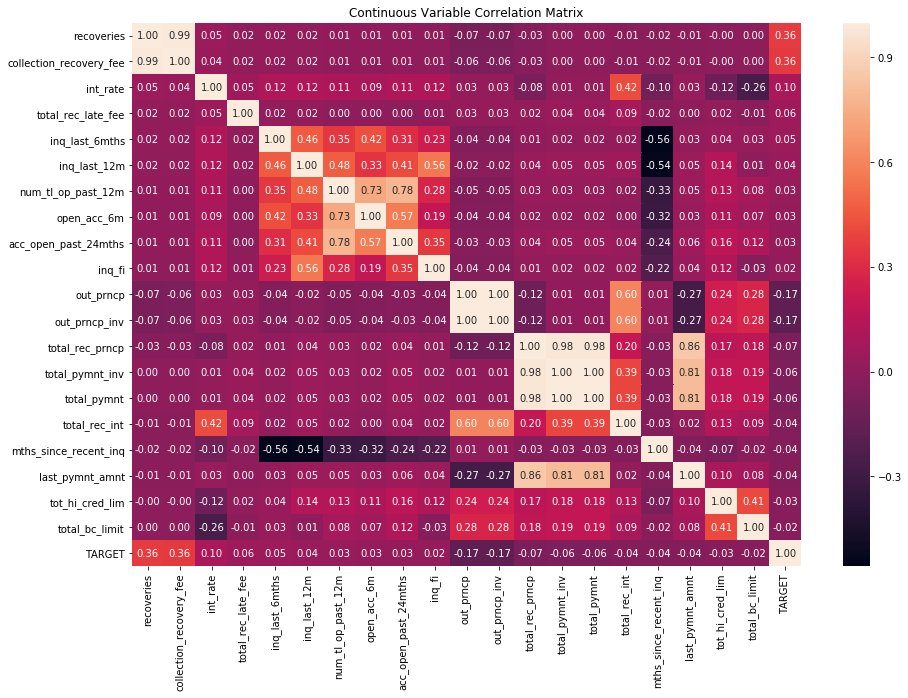

In [16]:
# Plot correlation matrix of TARGET and continuous variables
# Top 20 correlated continuous variables
var_contns_corr = df_contns_pos_corr.index.tolist() + df_contns_neg_corr.index.tolist()

plt.figure(figsize=[15, 10])
sns.heatmap(df[var_contns_corr + ['TARGET']].corr(), annot=True, fmt='.2f')
plt.title('Continuous Variable Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [17]:
# Display DEFAULT Descriptive Statistics Table of top 20 correlated continuous variables
df_desc_stat_default = df.loc[df['TARGET'] == 1, var_contns_corr].describe().T
df_desc_stat_default = df_desc_stat_default.drop(columns=['count'])
df_desc_stat_default = round(df_desc_stat_default, 2)

display(df_desc_stat_default)
print(f'Dataframe has {df_desc_stat_default.shape[0]} continuous variables with ' +
      f'{df_desc_stat_default.shape[1]} measures.')

,mean,std,min,25%,50%,75%,max
recoveries,510.57,1295.64,0.00,0.00,0.00,0.00,33122.07
collection_recovery_fee,88.59,228.73,0.00,0.00,0.00,0.00,5961.97
int_rate,0.16,0.06,0.05,0.12,0.15,0.20,0.31
total_rec_late_fee,3.10,13.09,0.00,0.00,0.00,0.00,304.55
inq_last_6mths,0.68,0.87,0.00,0.00,0.00,1.00,5.00
inq_last_12m,2.60,2.89,0.00,1.00,2.00,4.00,40.00
num_tl_op_past_12m,2.42,2.06,0.00,1.00,2.00,3.00,16.00
open_acc_6m,1.10,1.25,0.00,0.00,1.00,2.00,11.00
acc_open_past_24mths,5.02,3.45,0.00,2.00,4.00,7.00,29.00
inq_fi,1.35,1.80,0.00,0.00,1.00,2.00,28.00


Dataframe has 20 continuous variables with 7 measures.


In [18]:
# Display NON-DEFAULT Descriptive Statistics Table of top 20 correlated continuous variables
df_desc_stat_nondefault = df.loc[df['TARGET'] == 0, var_contns_corr].describe().T
df_desc_stat_nondefault = df_desc_stat_nondefault.drop(columns=['count'])
df_desc_stat_nondefault = round(df_desc_stat_nondefault, 2)

display(df_desc_stat_nondefault)
print(f'Dataframe has {df_desc_stat_nondefault.shape[0]} continuous variables with ' +
      f'{df_desc_stat_nondefault.shape[1]} measures.')

,mean,std,min,25%,50%,75%,max
recoveries,0.00,0.00,0.00,0.00,0.00,0.00,0.00
collection_recovery_fee,0.00,0.00,0.00,0.00,0.00,0.00,0.00
int_rate,0.13,0.05,0.05,0.08,0.12,0.15,0.31
total_rec_late_fee,0.51,5.95,0.00,0.00,0.00,0.00,524.08
inq_last_6mths,0.44,0.72,0.00,0.00,0.00,1.00,5.00
inq_last_12m,1.92,2.35,0.00,0.00,1.00,3.00,67.00
num_tl_op_past_12m,2.02,1.89,0.00,1.00,2.00,3.00,26.00
open_acc_6m,0.89,1.12,0.00,0.00,1.00,1.00,15.00
acc_open_past_24mths,4.41,3.23,0.00,2.00,4.00,6.00,54.00
inq_fi,1.08,1.49,0.00,0.00,1.00,2.00,38.00


Dataframe has 20 continuous variables with 7 measures.


In [19]:
# Compare median of continuous variables between DEFAULT and NON-DEFAULT
df_compare_median = df_desc_stat_default[['50%']].join(df_desc_stat_nondefault[['50%']],
                        lsuffix='_default', rsuffix='_nondefault')
df_compare_median.loc[df_compare_median['50%_default'] >
    df_compare_median['50%_nondefault'], 'larger'] = 'DEFAULT'
df_compare_median.loc[df_compare_median['50%_default'] <
    df_compare_median['50%_nondefault'], 'larger'] = 'NON-DEFAULT'
df_compare_median['diff'] = abs(df_compare_median['50%_default'] - df_compare_median['50%_nondefault'])
display(df_compare_median)

,50%_default,50%_nondefault,larger,diff
recoveries,0.00,0.00,NaN,0.00
collection_recovery_fee,0.00,0.00,NaN,0.00
int_rate,0.15,0.12,DEFAULT,0.03
total_rec_late_fee,0.00,0.00,NaN,0.00
inq_last_6mths,0.00,0.00,NaN,0.00
inq_last_12m,2.00,1.00,DEFAULT,1.00
num_tl_op_past_12m,2.00,2.00,NaN,0.00
open_acc_6m,1.00,1.00,NaN,0.00
acc_open_past_24mths,4.00,4.00,NaN,0.00
inq_fi,1.00,1.00,NaN,0.00


In [20]:
# Function to calculate Cramer's V coefficient between 2 categorical variables
# Refer to https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# Refer to https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

In [21]:
# Cramer's V association analysis between TARGET and categorical variables
df_cramers = pd.DataFrame(var_ctgry + ['TARGET'], columns=['Variable']).set_index('Variable')
df_cramers.index.names = [None]

for var_x in df_cramers.index:
    for var_y in df_cramers.index:
        if var_x == var_y:
            df_cramers.loc[var_x, var_y] = 1
        else:
            df_cramers.loc[var_x, var_y] = cramers_v(df[var_x], df[var_y])

df_target_cramers = pd.DataFrame(round(df_cramers['TARGET'].sort_values(ascending=False), 4)).rename(
    columns={'TARGET': 'CVC'})
df_target_cramers = df_target_cramers.loc[df_target_cramers.index != 'TARGET']

print('Cramer\'s V Coefficient between Categorical Variables with TARGET:')
display(df_target_cramers)

Cramer's V Coefficient between Categorical Variables with TARGET:


,CVC
debt_settlement_flag,0.2129
sub_grade,0.1065
grade,0.1015
verification_status,0.0478
purpose,0.0437
title,0.0436
home_ownership,0.0284
term,0.0246
initial_list_status,0.0218
emp_length,0.0099


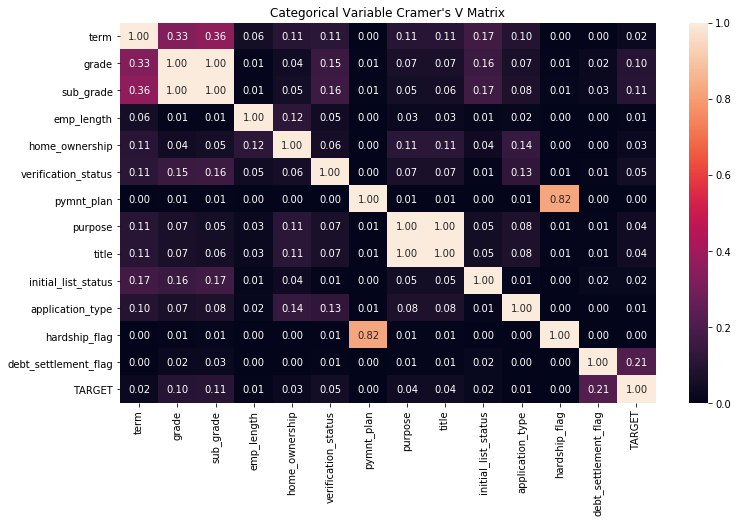

In [22]:
# Plot Cramer's V matrix of TARGET and categorical variables
plt.figure(figsize=[12, 7])
sns.heatmap(df_cramers, annot=True, fmt='.2f')
plt.title('Categorical Variable Cramer\'s V Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [23]:
# Top associated categorical variables (CVC > 0.02)
print('Top TARGET Associated Categorical Variables:')
df_target_cramers = df_target_cramers.loc[df_target_cramers['CVC'] > 0.02]
display(df_target_cramers)

Top TARGET Associated Categorical Variables:


,CVC
debt_settlement_flag,0.2129
sub_grade,0.1065
grade,0.1015
verification_status,0.0478
purpose,0.0437
title,0.0436
home_ownership,0.0284
term,0.0246
initial_list_status,0.0218


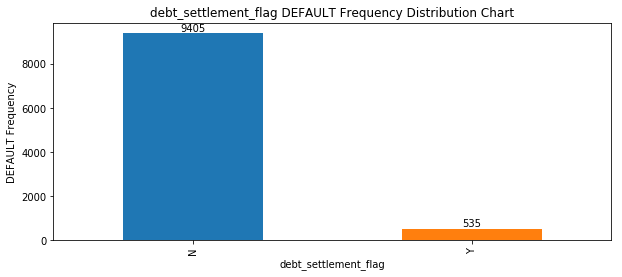

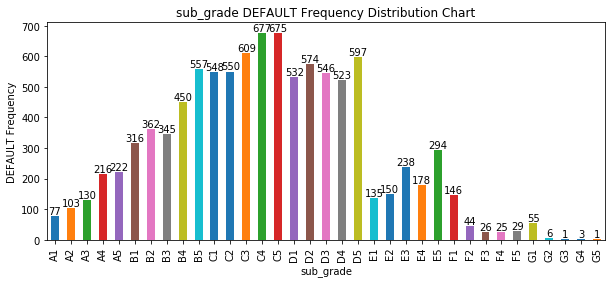

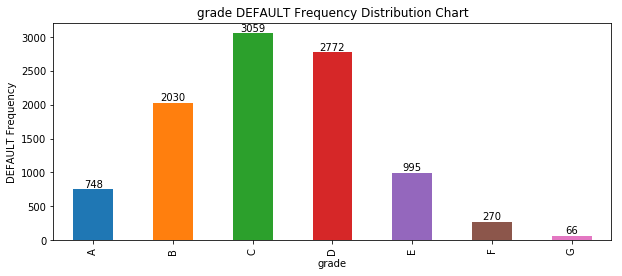

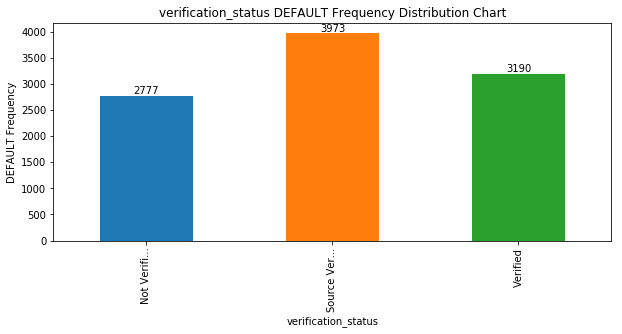

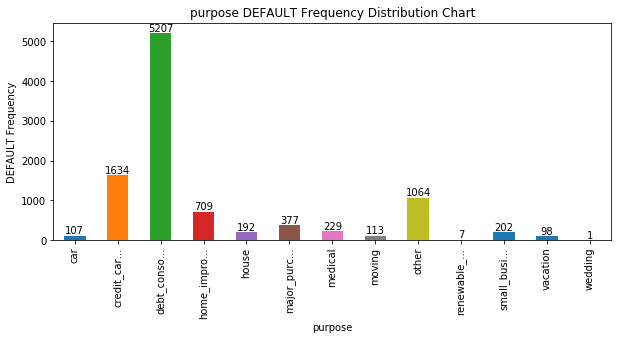

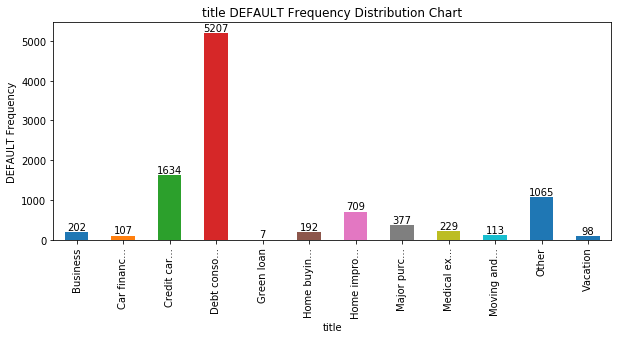

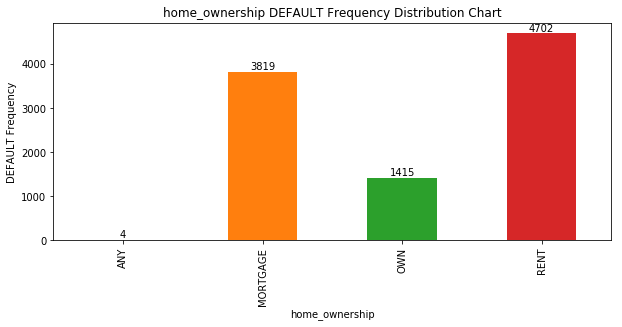

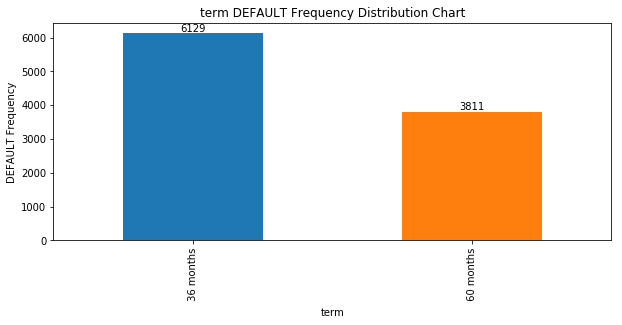

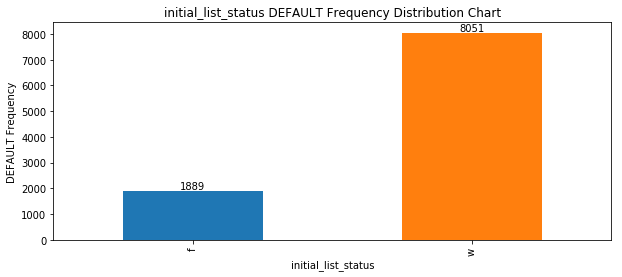

In [24]:
# Display DEFAULT Frequency Distribution Chart of top associated categorical variables
var_ctgry_cramers = df_target_cramers.index.tolist()

for var in var_ctgry_cramers:
    plt.figure(figsize=[10, 4])
    ax = df.loc[df['TARGET'] == 1, var].value_counts().sort_index().plot(kind='bar')
    ax.set_title(f'{var} DEFAULT Frequency Distribution Chart')
    ax.set_xlabel(f'{var}')
    ax.set_ylabel('DEFAULT Frequency')
    ax.set_xticklabels([x[:10] + '...' if len(x) > 10 else x for x in sorted(
        df[var].value_counts().index)])
    add_value_labels(ax)
    plt.show()

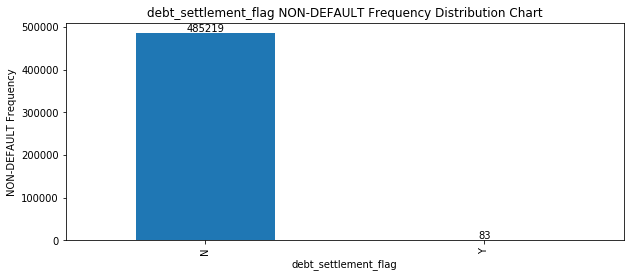

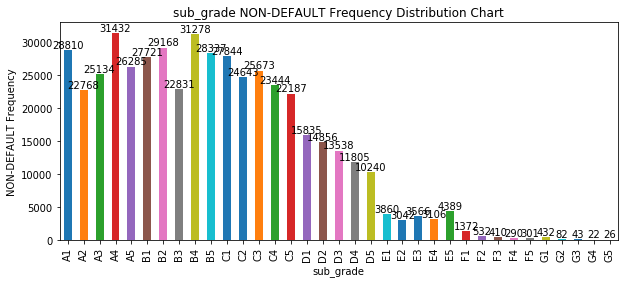

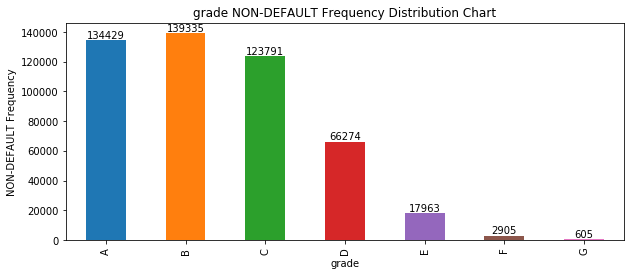

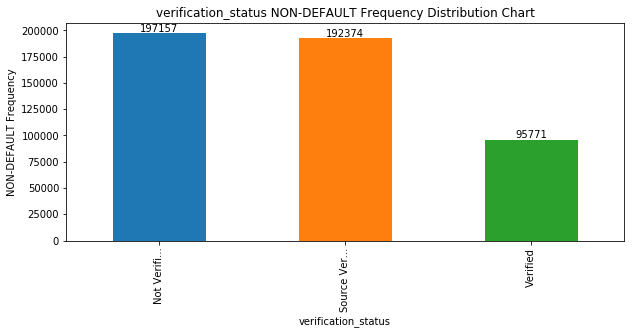

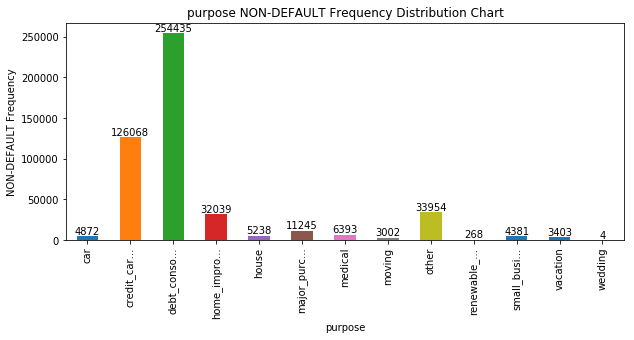

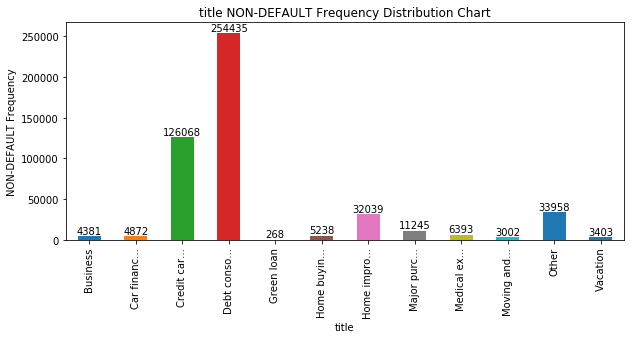

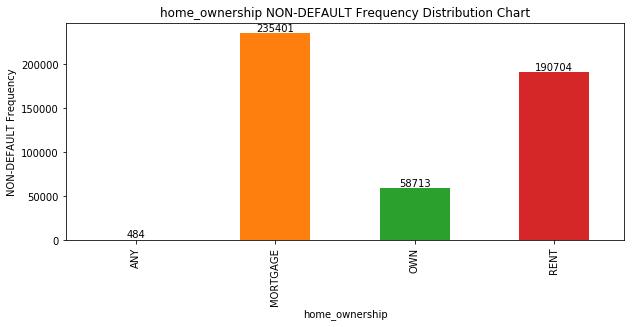

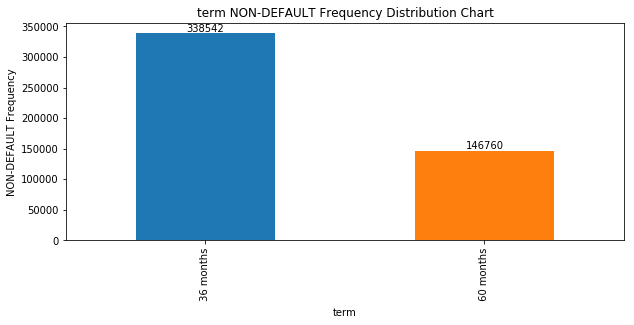

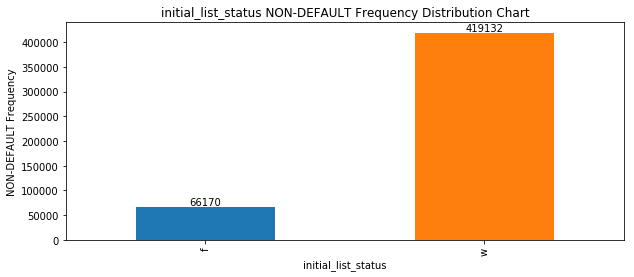

In [25]:
# Display NON-DEFAULT Frequency Distribution Chart of top associated categorical variables
for var in var_ctgry_cramers:
    plt.figure(figsize=[10, 4])
    ax = df.loc[df['TARGET'] == 0, var].value_counts().sort_index().plot(kind='bar')
    ax.set_title(f'{var} NON-DEFAULT Frequency Distribution Chart')
    ax.set_xlabel(f'{var}')
    ax.set_ylabel('NON-DEFAULT Frequency')
    ax.set_xticklabels([x[:10] + '...' if len(x) > 10 else x for x in sorted(
        df[var].value_counts().index)])
    add_value_labels(ax)
    plt.show()

In [26]:
# Free up the memory
del df_init

In [27]:
# Work on a copy of the dataframe for data preparation
df_model = df.copy()

In [28]:
# Prepare dataframe for modeling
df_model = df_model[['TARGET'] + var_contns_corr + var_ctgry_cramers]

display(df_model[:5])
print('There are %d rows and %d columns in dataframe.' % (df_model.shape))

,TARGET,recoveries,collection_recovery_fee,int_rate,total_rec_late_fee,inq_last_6mths,inq_last_12m,num_tl_op_past_12m,open_acc_6m,acc_open_past_24mths,...,total_bc_limit,debt_settlement_flag,sub_grade,grade,verification_status,purpose,title,home_ownership,term,initial_list_status
0,0,0.0,0.0,0.2185,0.0,1,3,0,0,2,...,3300,N,D5,D,Source Verified,debt_consolidation,Debt consolidation,MORTGAGE,60 months,w
1,0,0.0,0.0,0.1261,0.0,1,4,6,1,13,...,12500,N,C1,C,Source Verified,home_improvement,Home improvement,MORTGAGE,60 months,w
2,0,0.0,0.0,0.3079,0.0,2,10,2,1,5,...,1900,N,G1,G,Not Verified,medical,Medical expenses,RENT,60 months,w
3,0,0.0,0.0,0.0607,0.0,0,0,0,0,2,...,39000,N,A2,A,Not Verified,debt_consolidation,Debt consolidation,MORTGAGE,36 months,w
4,0,0.0,0.0,0.1041,0.0,0,1,1,0,4,...,5200,N,B3,B,Not Verified,credit_card,Credit card refinancing,RENT,36 months,w


There are 495242 rows and 30 columns in dataframe.


In [29]:
# Export dataframe to CSV
df_model.to_csv('LoanStats_2018.csv', index=False, quoting=2)

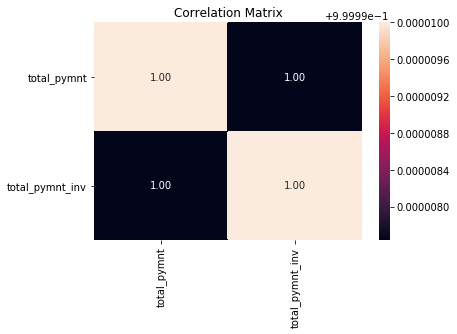

In [30]:
# Plot correlation matrix of redundant variable pair (total_pymnt, total_pymnt_inv)
plt.figure()
sns.heatmap(df[['total_pymnt', 'total_pymnt_inv']].corr(), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

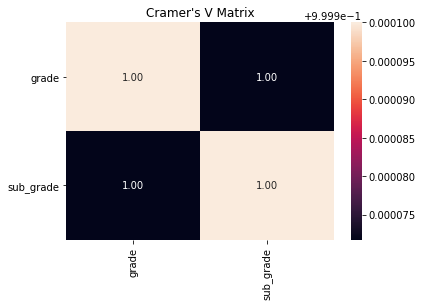

In [31]:
# Plot Cramer's V matrix of redundant variable pair (grade, sub_grade)
plt.figure()
sns.heatmap(df_cramers.loc[df_cramers.index.isin(['grade', 'sub_grade']),
    ['grade', 'sub_grade']], annot=True, fmt='.2f')
plt.title('Cramer\'s V Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [32]:
# Drop redundant variables
var_drop = ['collection_recovery_fee', # highly correlated with 'recoveries'
            'num_tl_op_past_12m', # highly correlated with 'open_acc_6m' and 'acc_open_past_24mths'
            'out_prncp_inv', # highly correlated with 'out_prncp'
            'total_pymnt_inv', 'total_pymnt', 'last_pymnt_amnt', # highly correlated with each others and 'total_rec_prncp'
            'sub_grade', # strongly associated with 'grade'
            #'pymnt_plan', # strongly associated with 'hardship_flag'
            'purpose' # strongly associated with 'title'
           ]

df_model = df_model.drop(columns=var_drop)
print(f'{len(var_drop)} columns dropped.')

display(df_model[:5])
print('There are %d rows and %d columns in dataframe.' % (df_model.shape))

8 columns dropped.


,TARGET,recoveries,int_rate,total_rec_late_fee,inq_last_6mths,inq_last_12m,open_acc_6m,acc_open_past_24mths,inq_fi,out_prncp,...,mths_since_recent_inq,tot_hi_cred_lim,total_bc_limit,debt_settlement_flag,grade,verification_status,title,home_ownership,term,initial_list_status
0,0,0.0,0.2185,0.0,1,3,0,2,4,21904.40,...,0.0,101234,3300,N,D,Source Verified,Debt consolidation,MORTGAGE,60 months,w
1,0,0.0,0.1261,0.0,1,4,1,13,2,8467.98,...,4.0,388400,12500,N,C,Source Verified,Home improvement,MORTGAGE,60 months,w
2,0,0.0,0.3079,0.0,2,10,1,5,8,10087.47,...,0.0,80367,1900,N,G,Not Verified,Medical expenses,RENT,60 months,w
3,0,0.0,0.0607,0.0,0,0,0,2,0,4463.33,...,NaN,289008,39000,N,A,Not Verified,Debt consolidation,MORTGAGE,36 months,w
4,0,0.0,0.1041,0.0,0,1,0,4,0,4203.24,...,11.0,31925,5200,N,B,Not Verified,Credit card refinancing,RENT,36 months,w


There are 495242 rows and 22 columns in dataframe.


In [33]:
# Missing value statistics
df_null_val = check_null(df_model)

display(df_null_val)

Dataframe has 22 columns, 1 of them have missing values.


,Data Type,Null Values (#),Null Values (%)
mths_since_recent_inq,float64,61305,12.38
TARGET,int64,0,0.00
out_prncp,float64,0,0.00
total_rec_prncp,float64,0,0.00
total_rec_late_fee,float64,0,0.00
total_rec_int,float64,0,0.00
total_bc_limit,int64,0,0.00
tot_hi_cred_lim,int64,0,0.00
title,object,0,0.00
term,object,0,0.00


In [34]:
# Impute missing value with median
print('Before imputation:')
display(df_model.loc[:4, ['mths_since_recent_inq']])

df_model['mths_since_recent_inq'] = df_model['mths_since_recent_inq'].fillna(
    df_model['mths_since_recent_inq'].median())
print('After imputation:')
display(df_model.loc[:4, ['mths_since_recent_inq']])

Before imputation:


,mths_since_recent_inq
0,0.0
1,4.0
2,0.0
3,NaN
4,11.0


After imputation:


,mths_since_recent_inq
0,0.0
1,4.0
2,0.0
3,6.0
4,11.0


In [35]:
# One-hot encoding categorical variables
print('Before encoding:')
display(df_model.loc[:4, ['term']])

df_model = pd.get_dummies(df_model)
print('After encoding:')
display(df_model.loc[:4, ['term_ 36 months', 'term_ 60 months']])

Before encoding:


,term
0,60 months
1,60 months
2,60 months
3,36 months
4,36 months


After encoding:


,term_ 36 months,term_ 60 months
0,0,1
1,0,1
2,0,1
3,1,0
4,1,0


In [36]:
# Missing value statistics
df_null_val = check_null(df_model)

display(df_null_val)

Dataframe has 47 columns, 0 of them have missing values.


,Data Type,Null Values (#),Null Values (%)
TARGET,int64,0,0.0
title_Medical expenses,uint8,0,0.0
term_ 60 months,uint8,0,0.0
title_Business,uint8,0,0.0
title_Car financing,uint8,0,0.0
title_Credit card refinancing,uint8,0,0.0
title_Debt consolidation,uint8,0,0.0
title_Green loan,uint8,0,0.0
title_Home buying,uint8,0,0.0
title_Home improvement,uint8,0,0.0


In [37]:
# Free up the memory
del df

In [38]:
# Train and test set for modeling
X_train, X_test, y_train, y_test = train_test_split(df_model.drop(columns='TARGET'), df_model['TARGET'],
    test_size=0.2, random_state=random_seed)

In [39]:
# Function to create classification report on test set
def print_score(clf, X_test, y_test):
    print(f'Accuracy Score: {round(accuracy_score(y_test, clf.predict(X_test)), 4)}')
    print(f'\nClassification Report:\n{classification_report(y_test, clf.predict(X_test))}')
    print(f'\nConfusion Matrix:\n{confusion_matrix(y_test, clf.predict(X_test))}')

In [40]:
# Generate Decision Tree model
model_dec_tree = DecisionTreeClassifier(max_depth=8, random_state=random_seed).fit(X_train, y_train)

In [41]:
# Test result for Decision Tree model
print_score(model_dec_tree, X_test, y_test)

Accuracy Score: 0.999

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     97051
          1       0.99      0.96      0.97      1998

avg / total       1.00      1.00      1.00     99049


Confusion Matrix:
[[97038    13]
 [   88  1910]]


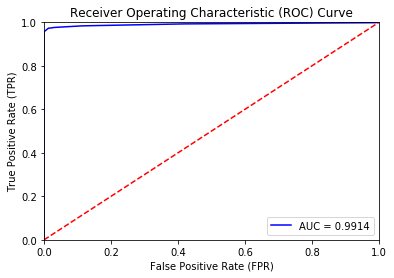

In [42]:
# Plot ROC curve of Decision Tree model
preds = model_dec_tree.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

In [43]:
# Generate Logistic Regression model
model_log_reg = LogisticRegression(C=0.0001, random_state=random_seed).fit(X_train, y_train)

In [44]:
# Test result for Logistic Regression model
print_score(model_log_reg, X_test, y_test)

Accuracy Score: 0.9987

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     97051
          1       1.00      0.94      0.97      1998

avg / total       1.00      1.00      1.00     99049


Confusion Matrix:
[[97046     5]
 [  127  1871]]


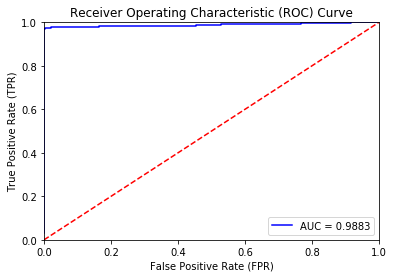

In [45]:
# Plot ROC curve of Logistic Regression model
preds = model_log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

In [46]:
# Generate XGBoost model
model_xgboost = XGBClassifier(seed=random_seed).fit(X_train, y_train)

In [47]:
# Test result for XGBoost model
print_score(model_xgboost, X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy Score: 0.9993


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     97051
          1       1.00      0.96      0.98      1998

avg / total       1.00      1.00      1.00     99049


Confusion Matrix:
[[97050     1]
 [   70  1928]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


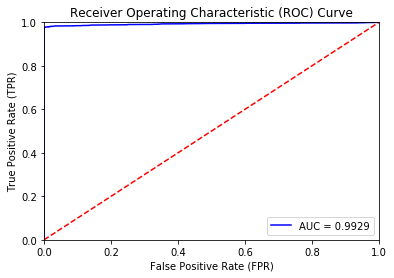

In [48]:
# Plot ROC curve of XGBoost model
preds = model_xgboost.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

<Figure size 432x288 with 0 Axes>

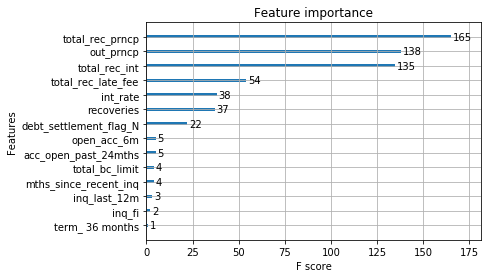

In [49]:
# Display XGBoost Feature Importance Chart
plt.figure()
plot_importance(model_xgboost)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy Score: 0.9993


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     97051
          1       1.00      0.96      0.98      1998

avg / total       1.00      1.00      1.00     99049



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Confusion Matrix:
[[97050     1]
 [   70  1928]]


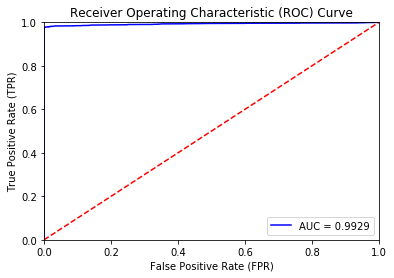

<Figure size 432x288 with 0 Axes>

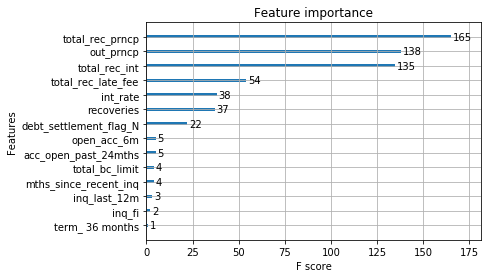

In [50]:
# Rebuild best model with only determinants from feature importance list
var = ['TARGET', 'total_rec_prncp', 'out_prncp', 'total_rec_int', 'total_rec_late_fee', 'int_rate', 'recoveries',
       'debt_settlement_flag_N', 'debt_settlement_flag_Y', 'open_acc_6m', 'acc_open_past_24mths', 'total_bc_limit',
       'mths_since_recent_inq', 'inq_last_12m', 'inq_fi', 'term_ 36 months', 'term_ 60 months']

# Train and test set for modeling
X_train, X_test, y_train, y_test = train_test_split(df_model[var].drop(columns='TARGET'), df_model['TARGET'],
    test_size=0.2, random_state=random_seed)

# Generate best model
model_best = XGBClassifier(seed=random_seed).fit(X_train, y_train)

# Test result for best model
print_score(model_best, X_test, y_test)

# Plot ROC curve of best model
preds = model_best.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

# Display best model Feature Importance Chart
plt.figure()
plot_importance(model_best)
plt.show()

In [51]:
# Save all models into pickle files
joblib.dump(model_dec_tree, 'model_dec_tree.pkl', compress=9)
joblib.dump(model_log_reg, 'model_log_reg.pkl', compress=9)
joblib.dump(model_xgboost, 'model_xgboost.pkl', compress=9)
joblib.dump(model_best, 'model_best.pkl', compress=9)

#model_clone = joblib.load('model_best.pkl')

['model_best.pkl']